In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve, 
    auc,
    RocCurveDisplay
)

from imblearn.over_sampling import SMOTE


In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features.set_axis(
    default_of_credit_card_clients.variables["description"].tolist()[1:-1],
    axis="columns",
)
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [6]:
y["Default"] = y["Y"].map({0: 1, 1: 0})
y = y.drop(columns=["Y"])
y.head()

C:\Users\sathv\AppData\Local\Temp\ipykernel_144976\424695830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Default"] = y["Y"].map({0: 1, 1: 0})


,Default
0,0
1,0
2,1
3,1
4,1


In [19]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [91]:
X.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [7]:
X["SEX"] = X["SEX"].map({1: "Male", 2: "Female"})
X["EDUCATION"] = X["EDUCATION"].map(
    {1: "Graduate School", 2: "University", 3: "High School", 4: "Other Education"}
)
X["MARRIAGE"] = X["MARRIAGE"].map(
    {1: "Married", 2: "Single", 3: "Other Marital Status"}
)

In [8]:
dummies_sex = pd.get_dummies(X["SEX"], drop_first=True).astype(int)
dummies_edu = pd.get_dummies(X["EDUCATION"]).astype(int)
dummies_mar = pd.get_dummies(X["MARRIAGE"]).astype(int)
# X = pd.concat([X.drop(columns=["SEX", "EDUCATION", "MARRIAGE"]), ).astype(int)], axis=1)
X = pd.concat(
    [
        dummies_sex,
        dummies_edu,
        dummies_mar,
        X.drop(columns=["SEX", "EDUCATION", "MARRIAGE"]),
    ],
    axis=1,
)
X.head()

,Male,Graduate School,High School,Other Education,University,Married,Other Marital Status,Single,LIMIT_BAL,AGE,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,0,0,0,1,1,0,0,20000,24,...,689,0,0,0,0,689,0,0,0,0
1,0,0,0,0,1,0,0,1,120000,26,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,0,0,0,1,0,0,1,90000,34,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,0,0,0,1,1,0,0,50000,37,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,1,0,0,0,1,1,0,0,50000,57,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [94]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Male                  30000 non-null  int64
 1   Graduate School       30000 non-null  int64
 2   High School           30000 non-null  int64
 3   Other Education       30000 non-null  int64
 4   University            30000 non-null  int64
 5   Married               30000 non-null  int64
 6   Other Marital Status  30000 non-null  int64
 7   Single                30000 non-null  int64
 8   LIMIT_BAL             30000 non-null  int64
 9   AGE                   30000 non-null  int64
 10  PAY_0                 30000 non-null  int64
 11  PAY_2                 30000 non-null  int64
 12  PAY_3                 30000 non-null  int64
 13  PAY_4                 30000 non-null  int64
 14  PAY_5                 30000 non-null  int64
 15  PAY_6                 30000 non-null  int64
 16  BILL

In [188]:
X.describe()

,Male,Graduate School,High School,Other Education,University,Married,Other Marital Status,Single,LIMIT_BAL,AGE,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,0.396267,0.352833,0.163900,0.004100,0.467667,0.455300,0.010767,0.532133,0.159075,0.249750,...,0.112157,0.200891,0.120620,0.290851,-3.247771e+00,-3.516081e+00,-3.432752e+00,-3.412281e+00,-3.317092e+00,-3.452569e+00
std,0.489129,0.477859,0.370191,0.063901,0.498962,0.498006,0.103204,0.498975,0.131058,0.158929,...,0.038076,0.060601,0.060284,0.045766,1.795228e+00,1.706172e+00,1.852187e+00,1.945186e+00,2.041655e+00,2.053994e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00,-7.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040404,0.120690,...,0.087808,0.162330,0.082396,0.261944,-2.941251e+00,-3.305676e+00,-3.361163e+00,-3.321709e+00,-3.227616e+00,-3.652028e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.131313,0.224138,...,0.097374,0.178084,0.098600,0.274097,-2.619051e+00,-2.923393e+00,-2.697033e+00,-2.616982e+00,-2.453845e+00,-2.547075e+00
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.232323,0.344828,...,0.119378,0.211482,0.130415,0.298787,-2.241790e+00,-2.527424e+00,-2.298624e+00,-2.189589e+00,-2.024477e+00,-2.121116e+00
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,4.342945e-08,4.342945e-08,4.342945e-08,4.342945e-08,4.342945e-08,4.342945e-08


In [96]:
y.head()

,Y
0,1
1,1
2,0
3,0
4,0


In [33]:
y.value_counts()

Default
1          23364
0           6636
Name: count, dtype: int64

In [9]:
X = (X - X.min()) / (X.max() - X.min())
X.head()

,Male,Graduate School,High School,Other Education,University,Married,Other Marital Status,Single,LIMIT_BAL,AGE,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.010101,0.051724,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.111111,0.086207,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.080808,0.224138,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.040404,0.275862,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.040404,0.620690,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [7]:
X.skew()

Male                     0.424183
Graduate School          0.615982
High School              1.815941
Other Education         15.521941
University               0.129611
Married                  0.179528
Other Marital Status     9.481515
Single                  -0.128806
LIMIT_BAL                0.992867
AGE                      0.732246
PAY_0                    0.731975
PAY_2                    0.790565
PAY_3                    0.840682
PAY_4                    0.999629
PAY_5                    1.008197
PAY_6                    0.948029
BILL_AMT1                2.663861
BILL_AMT2                2.705221
BILL_AMT3                3.087830
BILL_AMT4                2.821965
BILL_AMT5                2.876380
BILL_AMT6                2.846645
PAY_AMT1                14.668364
PAY_AMT2                30.453817
PAY_AMT3                17.216635
PAY_AMT4                12.904985
PAY_AMT5                11.127417
PAY_AMT6                10.640727
dtype: float64

In [10]:
X[X.columns[-6:]] = X[X.columns[-6:]].apply(lambda x: np.log10(x + 1e-7))
X[X.columns[-6:]].skew()

PAY_AMT1   -1.442865
PAY_AMT2   -1.360772
PAY_AMT3   -1.233950
PAY_AMT4   -1.139079
PAY_AMT5   -1.110936
PAY_AMT6   -1.012108
dtype: float64

In [11]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

d:\Apps\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32709, 28), (14019, 28), (32709, 1), (14019, 1))

In [25]:
alphas = [0.01, 0.1, 1, 10, 100]
Cs = [1 / alpha for alpha in alphas]

model_logistic = LogisticRegressionCV(Cs=Cs, penalty="l2", max_iter=1000, scoring='recall')
model_logistic.fit(X_train, y_train.to_numpy().reshape(y_train.shape[0]))
model.C_

array([0.1])

<Axes: >

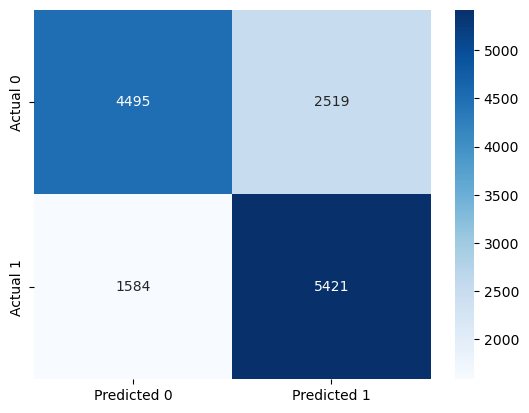

In [45]:
y_pred_l = model_logistic.predict(X_test)
cm = confusion_matrix(y_test, y_pred_l).astype(int)
tn, fp, fn, tp = cm.ravel()
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)

In [29]:
rforest = RandomForestClassifier(n_estimators=100,random_state=42)
rforest.fit(X_train, y_train.to_numpy().reshape(y_train.shape[0]))

RandomForestClassifier(random_state=42)

(14019,)


<Axes: >

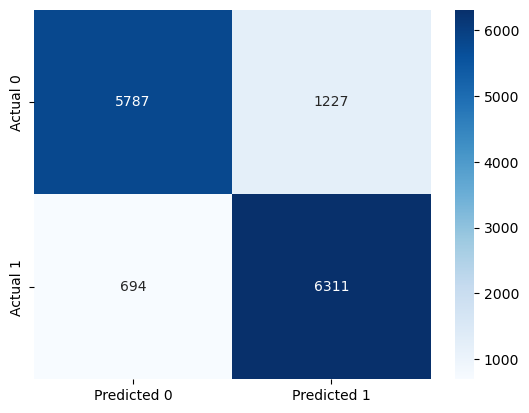

In [71]:
y_pred_r = rforest.predict(X_test)
cm = confusion_matrix(y_test, y_pred_r).astype(int)
tn, fp, fn, tp = cm.ravel()
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)

In [92]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [98]:
params = {"objective": "binary:logistic", 
          "learning_rate": 0.1}
n = 10000
evals = [(dtrain, "train"), (dtest, "validation")]

clf_xgb = xgb.train(
    params=params,
    dtrain=dtrain, 
    num_boost_round=n, 
    evals=evals, 
    verbose_eval=50, 
    early_stopping_rounds=50
)


[0]	train-logloss:0.65985	validation-logloss:0.66099


[50]	train-logloss:0.37140	validation-logloss:0.39690
[100]	train-logloss:0.31676	validation-logloss:0.35921
[150]	train-logloss:0.28088	validation-logloss:0.33866
[200]	train-logloss:0.25695	validation-logloss:0.32820
[250]	train-logloss:0.23795	validation-logloss:0.32206
[300]	train-logloss:0.22199	validation-logloss:0.31733
[350]	train-logloss:0.20594	validation-logloss:0.31326
[400]	train-logloss:0.19344	validation-logloss:0.31176
[450]	train-logloss:0.18201	validation-logloss:0.31096
[500]	train-logloss:0.17099	validation-logloss:0.31042
[550]	train-logloss:0.16207	validation-logloss:0.31033
[566]	train-logloss:0.15954	validation-logloss:0.31022


<Axes: >

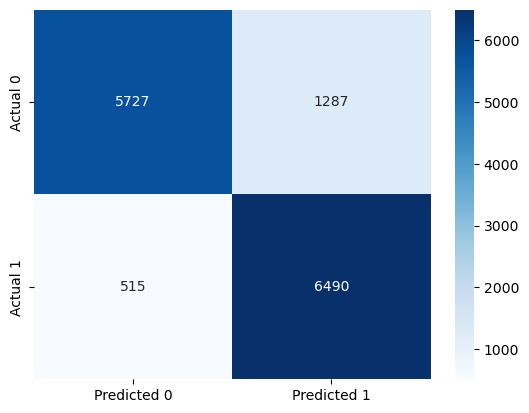

In [99]:
y_pred_x = np.around(clf_xgb.predict(dtest))
cm = confusion_matrix(y_test, y_pred_x)
tn, fp, fn, tp = cm.ravel()
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)

In [89]:
np.unique(y_test)

array([0, 1], dtype=int64)

In [100]:
print(f"\n{'-'*20} {"Logistic Regression"} {'-'*20}")
print(classification_report(y_test, y_pred_l))
print(f"\n{'-'*20} {"Random Forest"} {'-'*20}")
print(classification_report(y_test, y_pred_r))
print(f"\n{'-'*20} {"XGBOOST"} {'-'*20}")
print(classification_report(y_test, y_pred_x))



-------------------- Logistic Regression --------------------
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      7014
           1       0.68      0.77      0.73      7005

    accuracy                           0.71     14019
   macro avg       0.71      0.71      0.71     14019
weighted avg       0.71      0.71      0.71     14019


-------------------- Random Forest --------------------
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      7014
           1       0.84      0.90      0.87      7005

    accuracy                           0.86     14019
   macro avg       0.87      0.86      0.86     14019
weighted avg       0.87      0.86      0.86     14019


-------------------- XGBOOST --------------------
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      7014
           1       0.83      0.93      0.88      7005

    accurac

In [2]:
x_proba = clf_xgb.predict(dtest)
fpr, tpr, thresh = roc_curve(y_test, x_proba)
auc_x = np.around(auc(fpr, tpr), 2)

NameError: name 'clf_xgb' is not defined

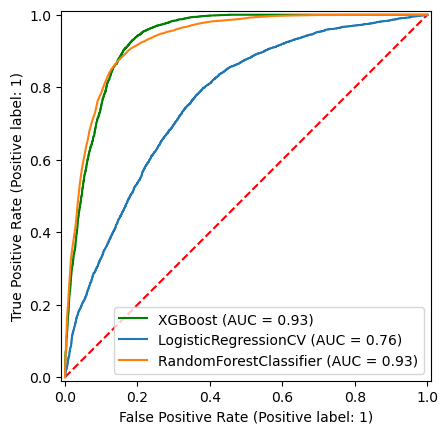

In [125]:
fig, ax = plt.subplots()

x_roc = ax.plot(fpr, tpr, color='green', label=f"XGBoost (AUC = {auc_x})")
ax.plot([0, 1], [0, 1], linestyle='--', color='red')
ax.legend(handles=x_roc)
RocCurveDisplay.from_estimator(model_logistic, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(rforest, X_test, y_test, ax=ax)
plt.show()